# This notebook shows example to load the CHGNet for prediction

In [ ]:
from __future__ import annotations

import numpy as np
from pymatgen.core import Structure

from chgnet.model.model import CHGNet

### Read structure from a json or cif file

In [ ]:
structure = Structure.from_file("./o-LiMnO2_unit.cif")
print(structure)

Full Formula (Li2 Mn2 O4)
Reduced Formula: LiMnO2
abc   :   2.868779   4.634475   5.832507
angles:  90.000000  90.000000  90.000000
Sites (8)
  #  SP      a    b         c
---  ----  ---  ---  --------
  0  Li+   0.5  0.5  0.37975
  1  Li+   0    0    0.62025
  2  Mn3+  0.5  0.5  0.863252
  3  Mn3+  0    0    0.136747
  4  O2-   0.5  0    0.360824
  5  O2-   0    0.5  0.098514
  6  O2-   0.5  0    0.901486
  7  O2-   0    0.5  0.639176


### Define Model

In [ ]:
chgnet = CHGNet.load()

# Or you can read your own model
# model = CHGNet.from_file(model_path)

CHGNet initialized with 400438 Parameters


# Predict energy, force, stress, magmom

In [ ]:
prediction = chgnet.predict_structure(structure)
print("CHGNet predicted energy:")
print(prediction["e"])
print("CHGNet predicted force:")
print(prediction["f"])
print("CHGNet predicted stress:")
print(prediction["s"])
print("CHGNet predicted magmom:")
print(prediction["m"])

CHGNet predicted energy:
-7.371591567993164
CHGNet predicted force:
[[ 4.4703484e-08 -4.2840838e-08  2.4071064e-02]
 [-4.4703484e-08 -1.4551915e-08 -2.4071217e-02]
 [-1.7881393e-07  1.0244548e-08  2.5402933e-02]
 [ 5.9604645e-08 -2.3283064e-08 -2.5402665e-02]
 [-1.1920929e-07  6.6356733e-08 -2.1660209e-02]
 [ 2.3543835e-06 -8.0077443e-06  9.5508099e-03]
 [-2.2947788e-06  7.9898164e-06 -9.5513463e-03]
 [-5.9604645e-08 -0.0000000e+00  2.1660626e-02]]
CHGNet predicted stress:
[[ 3.3677638e-01 -3.7330341e-07 -5.1117036e-06]
 [ 1.0701370e-06  2.4674933e-01  1.8477700e-05]
 [-4.4460303e-06  1.9265182e-05  4.0324528e-02]]
CHGNet predicted magmom:
[0.00521556 0.0052153  3.8572898  3.8572903  0.02538028 0.03706942
 0.03706949 0.02538028]


# Structure Optimization

In [ ]:
from chgnet.model import StructOptimizer

relaxer = StructOptimizer()

CHGNet initialized with 400438 Parameters


In [ ]:
result = relaxer.relax(structure, steps=10)
print("CHGNet relaxed structure")
print(result["final_structure"])

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 01:47:21      -58.972733*       0.1630
FIRE:    1 01:47:21      -58.972851*       0.1348
FIRE:    2 01:47:21      -58.972923*       0.0688
CHGNet relaxed structure
Full Formula (Li2 Mn2 O4)
Reduced Formula: LiMnO2
abc   :   2.865072   4.628857   5.833245
angles:  90.000002  89.999998  90.000001
Sites (8)
  #  SP       a     b         c      magmom
---  ----  ----  ----  --------  ----------
  0  Li+    0.5   0.5  0.379802  0.00517052
  1  Li+   -0    -0    0.620198  0.00517061
  2  Mn3+   0.5   0.5  0.863306  3.85418
  3  Mn3+  -0     0    0.136694  3.85418
  4  O2-    0.5  -0    0.360787  0.025221
  5  O2-    0     0.5  0.098542  0.0369351
  6  O2-    0.5   0    0.901458  0.0369353
  7  O2-   -0     0.5  0.639213  0.025221


# Molecular Dynamics

In [ ]:
from chgnet.model.dynamics import MolecularDynamics

md = MolecularDynamics(
    atoms=structure,
    model=chgnet,
    ensemble="nvt",
    compressibility_au=1.6,
    temperature=1000,  # in k
    timestep=2,  # in fs
    trajectory="md_out.traj",
    logfile="md_out.log",
    loginterval=100,
    use_device="cpu",  # use 'cuda' for faster MD
)
md.run(50)  # run a 0.1 ps MD simulation

/Users/bowendeng/miniforge3/lib/python3.9/site-packages/ase/md/nvtberendsen.py:95: RuntimeWarning: divide by zero encountered in double_scalars
  (self.temperature / old_temperature - 1.0) *


# Magmom Visualization

In [ ]:
supercell = structure.copy()
supercell.make_supercell([2, 2, 2])
print(supercell.composition)

Li+16 Mn3+16 O2-32


In [ ]:
import random

n_Li = supercell.composition.as_dict()["Li+"]
remove_ids = random.sample(list(np.arange(n_Li)), int(n_Li / 2))

supercell.remove_sites(remove_ids)
print(supercell.composition)

Li+8 Mn3+16 O2-32


In [ ]:
result = relaxer.relax(supercell, steps=500, verbose=True)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 02:13:58     -425.880188*      21.1362
FIRE:    1 02:13:58     -399.534912*     270.2558
FIRE:    2 02:13:59     -425.745579*      50.8858
FIRE:    3 02:13:59     -427.081738*       4.8638
FIRE:    4 02:14:00     -426.017120*      53.2368
FIRE:    5 02:14:00     -426.655079*      35.8028
FIRE:    6 02:14:01     -427.191620*       8.6788
FIRE:    7 02:14:01     -427.113461*      16.4483
FIRE:    8 02:14:01     -427.133301*      15.4336
FIRE:    9 02:14:02     -427.168655*      13.4499
FIRE:   10 02:14:02     -427.211727*      10.5775
FIRE:   11 02:14:03     -427.253170*       6.9844
FIRE:   12 02:14:03     -427.284840*       2.9885
FIRE:   13 02:14:04     -427.302410*       2.1108
FIRE:   14 02:14:04     -427.308605*       4.6919
FIRE:   15 02:14:04     -427.309460*       4.6109
FIRE:   16 02:14:05     -427.311142*       4.4498
FIRE:   17 02:14:05     -427.313599*       4.2130
FI

FIRE:  162 02:15:09     -430.250275*       3.8172
FIRE:  163 02:15:09     -430.259167*       0.1797
FIRE:  164 02:15:09     -430.252945*       3.5215
FIRE:  165 02:15:10     -430.256096*       2.6313
FIRE:  166 02:15:10     -430.259514*       1.0901
FIRE:  167 02:15:11     -430.260155*       0.6881
FIRE:  168 02:15:11     -430.260208*       0.6465
FIRE:  169 02:15:12     -430.260288*       0.5649
FIRE:  170 02:15:12     -430.260422*       0.4496
FIRE:  171 02:15:12     -430.260555*       0.3081
FIRE:  172 02:15:13     -430.260689*       0.1791
FIRE:  173 02:15:13     -430.260822*       0.1789
FIRE:  174 02:15:14     -430.260956*       0.1787
FIRE:  175 02:15:14     -430.261116*       0.2645
FIRE:  176 02:15:14     -430.261303*       0.3426
FIRE:  177 02:15:15     -430.261543*       0.3594
FIRE:  178 02:15:15     -430.261917*       0.3000
FIRE:  179 02:15:16     -430.262371*       0.1781
FIRE:  180 02:15:16     -430.262878*       0.1781
FIRE:  181 02:15:17     -430.263493*       0.2054


In [ ]:
magmom_initial = chgnet.predict_structure(supercell)["m"]
magmom_relaxed = result["final_structure"].site_properties["magmom"]

In [ ]:
bins = np.histogram(np.hstack((magmom_initial, magmom_relaxed)), bins=40)[
    1
]  # get the bin edges

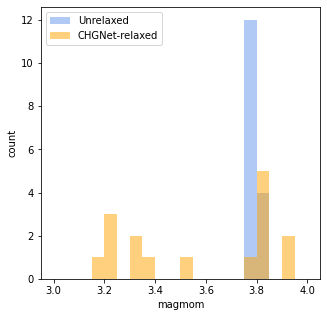

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=((5, 5)))
ax = fig.add_subplot()
# ax.set_title(r'Na$_2$V$_2$(PO$_4$)$_3$ magmom')
ax.set_xlabel("magmom")
ax.set_ylabel("count")

bins = np.histogram(np.hstack((magmom_initial, magmom_relaxed)), range=[3, 4], bins=20)[
    1
]
ax.hist(
    magmom_initial[8:24], bins, alpha=0.5, color="cornflowerblue", label="Unrelaxed"
)
ax.hist(magmom_relaxed[8:24], bins, alpha=0.5, color="orange", label="CHGNet-relaxed")

ax.legend()